# Steered Variational AutoEncoder

**Note: if such a method already exists under a different name, I am simply not aware of it**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [73]:
import numpy as np
import tensorflow as tf

from tensorflow.distributions import Normal
from tensorflow.distributions import Bernoulli

# modified version
class VariationalAutoencoder:
    
    def __init__(self, n_input, n_list, n_y=None):
        # input data
        self.X = tf.placeholder(tf.float32, shape=(None, n_input))
        if (n_y is not None):
            self.y = tf.placeholder(tf.float32, shape=(None, n_y))
        
        # encoder
        self.encoder_layers = []
        # input layer
        previous = n_input
        # current is the output of each layer (skip last because there is nothing after it)
        for current in n_list[:-1]:
            h = DenseLayer(previous,current)
            self.encoder_layers.append(h)
            previous = current
        # latent features number
        latent = n_list[-1]
        encoder_output = DenseLayer(current,latent*2,activation='none')
        self.encoder_layers.append(encoder_output)
        
        # feed forward through encoder
        c_X = self.X
        for layer in self.encoder_layers:
            c_X = layer.feed_forward(c_X)
        # c_X now holds the output of the encoder
        # first half are the means
        self.means = c_X[:,:latent]
        # second half are the std; must be positive; +1e-6 for smoothing
        self.std = tf.nn.softplus(c_X[:,latent:]) + 1e-6
        
        # optional loss for directed latent features
        if (n_y is not None):
            self.yhat = self.means[:,:n_y]
            self.error = tf.losses.mean_squared_error(labels=self.y,predictions=self.yhat)
        
        # reparameterization trick
        normal = Normal(loc=self.means,scale=self.std)
        self.Z = normal.sample()
                
        # decoder
        self.decoder_layers = []
        previous = latent
        for current in reversed(n_list[:-1]):
            h = DenseLayer(previous,current)
            self.decoder_layers.append(h)
            previous = current
        # output is the reconstruction
        decoder_output = DenseLayer(previous,n_input,activation=lambda x:x)
        self.decoder_layers.append(decoder_output)

        #feed forward through decoder, using the sampled 'data'
        c_X = self.Z
        for layer in self.decoder_layers:
            c_X = layer.feed_forward(c_X)
        logits = c_X
        # use logits for cost function below
        neg_cross_entropy = -tf.nn.sigmoid_cross_entropy_with_logits(labels=self.X,
                    logits=logits)
        neg_cross_entropy = tf.reduce_sum(neg_cross_entropy, 1)
        
        # output
        self.y_prob = Bernoulli(logits=logits)
        
        # sample from output
        self.post_pred = self.y_prob.sample()
        self.post_pred_probs = tf.nn.sigmoid(logits)
        
        # generate 'de-novo' output
        self.gen = tf.Variable(0)
        Z_std = Normal(0.0,1.0).sample([self.gen,latent])
        c_X = Z_std
        for layer in self.decoder_layers:
            c_X = layer.feed_forward(c_X)
        logits = c_X
        
        prior_pred_dist = Bernoulli(logits=logits)
        self.prior_pred = prior_pred_dist.sample()
        self.prior_pred_probs = tf.nn.sigmoid(logits)
        
        # manually input Z
        self.Z_input = tf.placeholder(np.float32, shape=(None, latent))
        c_X = self.Z_input
        for layer in self.decoder_layers:
            c_X = layer.feed_forward(c_X)
        logits = c_X
        self.manual_prior_prob = tf.nn.sigmoid(logits)
        
        # cost function
        # Kullback–Leibler divergence
        kl = -tf.log(self.std) + 0.5*(self.std**2 + self.means**2) - 0.5
        kl = tf.reduce_sum(kl, axis=1)
        # ELBO
        self.elbo = tf.reduce_sum(neg_cross_entropy - kl)
        
        if (n_y is None):
            self.optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(-self.elbo)
        else:
            self.optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(
                tf.reduce_sum(100*self.error-self.elbo))
               
        self.init = tf.global_variables_initializer()
        self.session = tf.Session()
        self.session.run(self.init)
    
    def steer(self,X,y,epochs=10,batch=50):
        '''Replaces fit, user provides the labels for the latent features'''
        n_batches = len(X) // batch
        for epoch in range(epochs):
            print('Epoch:',epoch+1)
            cost = 0
            e_cost = 0
            for b in range(n_batches):
                c_batch = X[b*batch:(b+1)*batch]
                y_batch = y[b*batch:(b+1)*batch]
                _,c,e, = self.session.run((self.optimizer, self.elbo,self.error),feed_dict={self.X: c_batch,self.y:y_batch})
                # accumulate cost
                cost+=c
                e_cost+=e
            print('Cost:', cost,e_cost)
    
    def fit(self,X,epochs=10,batch=50):
        n_batches = len(X) // batch
        for epoch in range(epochs):
            print('Epoch:',epoch+1)
            cost = 0
            for b in range(n_batches):
                c_batch = X[b*batch:(b+1)*batch]
                _,c, = self.session.run((self.optimizer, self.elbo),feed_dict={self.X: c_batch})
                # accumulate cost
                cost+=c
            print('Cost:', cost)
                       
    def predict(self,X,out='prob'):
        '''
        Pass data through encoder and decoder and retrieve reconstructed output
            by default the probabilities are returned, user can specify 'sample' or 'both'
        '''
        # correct shape if needed
        if (X.ndim==1):
            X = X.reshape([1,-1])
        pred,prob,mm = self.session.run((self.post_pred,self.post_pred_probs,self.means),feed_dict={self.X:X})
        if (out=='prob'):
            return prob,mm
        elif (out=='sample'):
            return pred
        else:
            return pred,prob

    def generate(self,n=1,out='prob'):
        '''
        Generate output
            by default the probabilities are returned, user can specify 'sample' or 'both'
            User specifies the number of points requested 
        '''
        pred,prob = self.session.run((self.prior_pred,self.prior_pred_probs),feed_dict={self.gen:n})
        if (out=='prob'):
            return prob
        elif (out=='sample'):
            return pred
        else:
            return pred,prob
    
    def feed(self,Z):
        '''Generate output using provided latent-space input Z'''
        # correct shape if needed
        if (Z.ndim==1):
            Z = Z.reshape([1,-1])
        return self.session.run(self.manual_prior_prob,feed_dict={self.Z_input:Z})
    
    def close(self):
        self.session.close()

class DenseLayer(object):
    '''A fully connected layer'''
    
    def __init__(self, n_in, n_out, activation=tf.nn.relu):
        '''number of input and output neurons; the activation function'''
        self.weights = tf.Variable(tf.random_normal(shape=(n_in, n_out), stddev=2/np.sqrt(n_in)))
        self.bias = tf.Variable(tf.constant(0.0,shape=[n_out]))
        if (activation=='none'):
            self.activation = lambda x: x
        else:
            self.activation = activation
            
    def feed_forward(self, X):
        '''Run input through layer and retrieve output'''
        return self.activation(tf.matmul(X, self.weights) + self.bias)

### Generate data

In [92]:
size = 100000
d = 8

center = np.random.randint(1,d-1,size=(size,2))
height = np.random.randint(1,d//2-1,size=size)
width =  np.random.randint(1,d//2-1,size=size)

X = np.zeros((size,d,d),dtype=int)
y = np.zeros((size,4))

# paint rectangles
for i in range (len(X)):
    left = min(max(center[i,0]-width[i]//2,0),d-1)
    right = min(max(center[i,0]+width[i]//2,0),d-1)
    top = min(max(center[i,1]+height[i]//2,0),d-1)
    bottom = min(max(center[i,1]-height[i]//2,0),d-1)
    # fix single lines
    if abs(left-right) < 3:
        if (left>0):
            left-=1
        if (right<d-1):
            right+=1
    if abs(bottom-top) < 3:
        if (bottom>0):
            bottom-=1
        if (top<d-1):
            top+=1
    X[i,top,left:right+1] = 1
    X[i,bottom,left:right] = 1
    X[i,bottom:top,left] = 1
    X[i,bottom:top,right] = 1
    y[i,0] = abs(top-bottom)+1
    y[i,1] = abs(left-right)+1
    y[i,2] = (top+bottom)/2
    y[i,3] = (left+right)/2

y = (y-y.mean(axis=0))/y.std(axis=0)

[-0.9255257   1.29809     1.57178787  0.94372816]


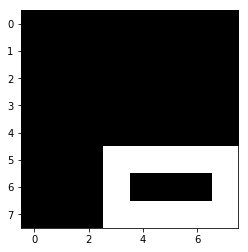

In [93]:
i = np.random.choice(range(len(X)))
print(y[i])
plt.imshow(X[i],cmap='gray')
plt.show()

In [94]:
# flatten
X = X.reshape(size,-1)
X.shape, y.shape

((100000, 64), (100000, 4))

### Generate and train encoder

In [77]:
vae = VariationalAutoencoder(64, [24,4],4)

In [96]:
vae.steer(X,y,epochs=5)

Epoch: 1
Cost: -945061.2065124512 928.3135843873024
Epoch: 2
Cost: -946956.0149536133 929.0393362045288
Epoch: 3
Cost: -949314.0523681641 928.4616147875786
Epoch: 4
Cost: -949629.3695983887 927.3976556956768
Epoch: 5
Cost: -952677.4588928223 922.5802194178104


### Reconstruction

[ 1.30049968  0.18422254 -0.31134832 -1.25327309]
[ 1.2344284  -0.37480196 -0.3050932  -1.6446443 ]


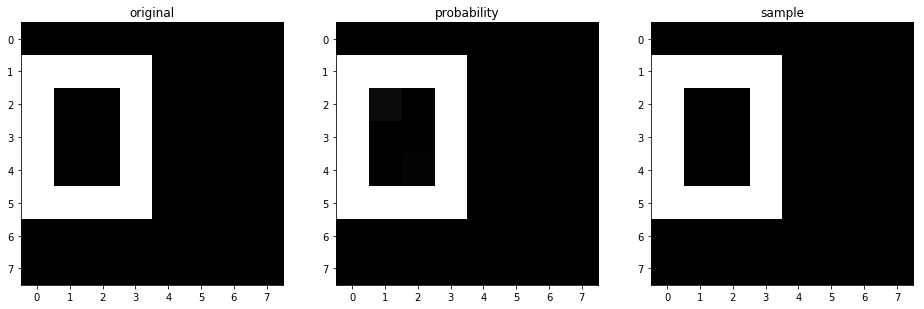

In [97]:
fig,axes = plt.subplots(ncols=3,figsize=(16,16))

i = np.random.choice(len(X))
aa,mm = vae.predict(X[i:i+3])
a = aa[0].reshape(d,d)
b = vae.predict(X[i],'sample')[0].reshape(d,d)

print(y[i])
print(mm[0])

axes[0].imshow(X[i].reshape(d,d),cmap='gray')
axes[0].set_title('original')
axes[1].imshow(a,cmap='gray')
axes[1].set_title('probability')
axes[2].imshow(b,cmap='gray')
axes[2].set_title('sample')
plt.show()

### Generation

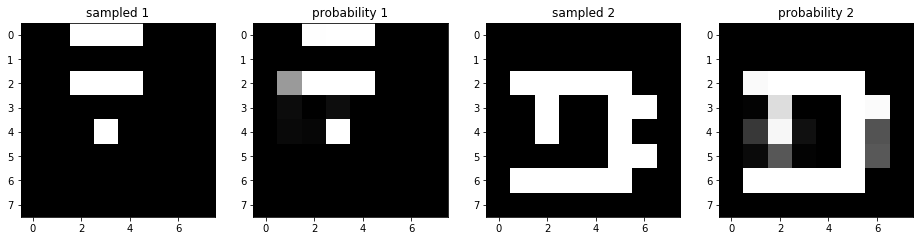

In [98]:
fig,axes = plt.subplots(ncols=4,figsize=(16,16))

c,dd = vae.generate(2,'both')
a,b = c[0].reshape(d,d), dd[0].reshape(d,d)
c,dd = c[1].reshape(d,d), dd[1].reshape(d,d)

axes[0].imshow(a,cmap='gray')
axes[0].set_title('sampled 1')
axes[1].imshow(b,cmap='gray')
axes[1].set_title('probability 1')
axes[2].imshow(c,cmap='gray')
axes[2].set_title('sampled 2')
axes[3].imshow(dd,cmap='gray')
axes[3].set_title('probability 2')
plt.show()

### Manual input to latent space

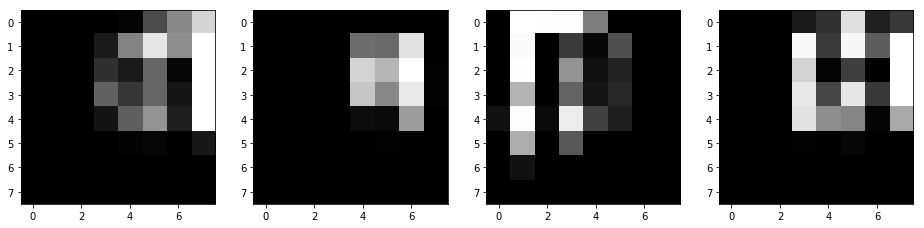

In [83]:
Z_input = np.random.normal(size=(4,4))

fig,axes = plt.subplots(ncols=4,figsize=(16,16))

g = vae.feed(Z_input)
a,b = g[0].reshape(d,d), g[1].reshape(d,d)
c,dd = g[2].reshape(d,d), g[3].reshape(d,d)

axes[0].imshow(a,cmap='gray')
axes[1].imshow(b,cmap='gray')
axes[2].imshow(c,cmap='gray')
axes[3].imshow(dd,cmap='gray')
plt.show()

### Observe latent space

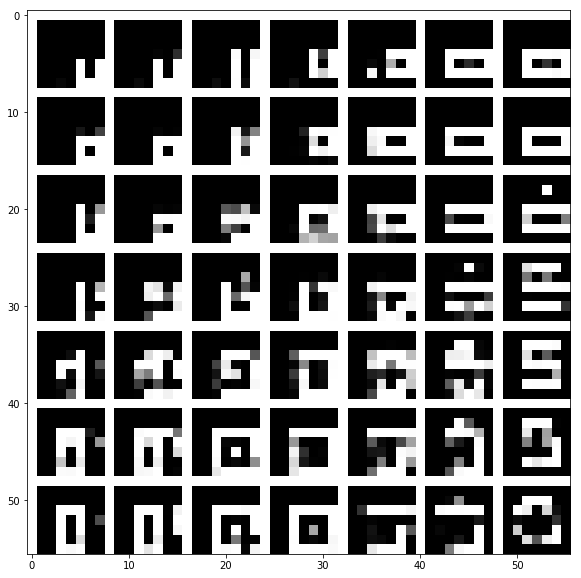

In [104]:
grid = 7
xs = np.linspace(-2, 2, grid)
ys = np.linspace(-2, 2, grid)
latent = np.empty((d * grid, d * grid))

manual_Z = []
for x in xs:
    for y in ys:
        manual_Z.append([y,x,1,1])
        
manual_Z = np.array(manual_Z)
g = vae.feed(manual_Z)

for x in range(grid):
    for y in range(grid):
        idx = x+y*grid
        current = g[idx].reshape(d,d)
        latent[x*d:(x+1)*d,y*d:(y+1)*d] = current
        latent[x*d,:] = 1
        latent[:,y*d] = 1

plt.figure(figsize=(10,10))
plt.imshow(latent,cmap='gray')
plt.show()

Overall, features 0 and 1 dicate the width and height, as trained

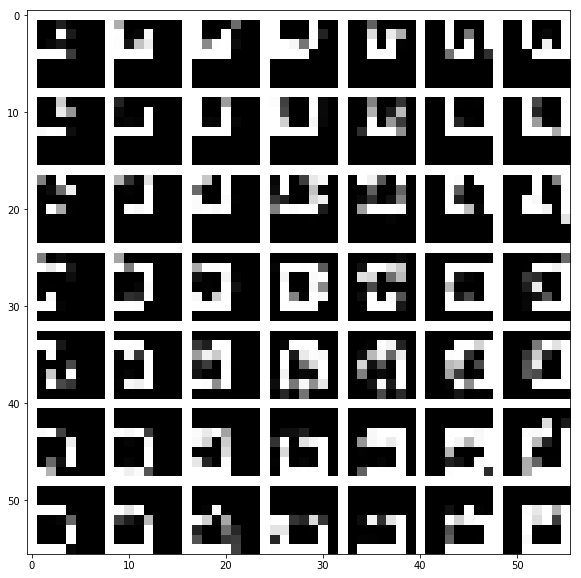

In [105]:
grid = 7
xs = np.linspace(-2, 2, grid)
ys = np.linspace(-2, 2, grid)
latent = np.empty((d * grid, d * grid))

manual_Z = []
for x in xs:
    for y in ys:
        manual_Z.append([1,1,y,x])
        
manual_Z = np.array(manual_Z)
g = vae.feed(manual_Z)

for x in range(grid):
    for y in range(grid):
        idx = x+y*grid
        current = g[idx].reshape(d,d)
        latent[x*d:(x+1)*d,y*d:(y+1)*d] = current
        latent[x*d,:] = 1
        latent[:,y*d] = 1

plt.figure(figsize=(10,10))
plt.imshow(latent,cmap='gray')
plt.show()

Indeed, position is mostly dictated by latent features 2 and 3, as trained